In [1]:
import math
import h5py
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

2.2.0+cu118


# TODO

Run model on test data 

Get R2 for test data per region on trained model

Build indicative plots for 1 simulation (preds and actual)



# CNN

### Prepare Data for CNN in PyTorch

In [2]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

In [3]:
PRECT = pd.read_csv('Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [4]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [5]:
y

array([[ 1.69681626],
       [-4.38486059],
       [ 2.35965193],
       ...,
       [ 1.42676119],
       [-2.24789536],
       [ 2.00405384]])

In [6]:
y = y.reshape(-1, 3)
y

array([[ 1.69681626, -4.38486059,  2.35965193],
       [ 7.414276  , 15.16454221, -0.27659118],
       [ 1.00511413, -0.24650046,  1.69304477],
       ...,
       [-2.79026449,  2.59703625, -4.35883811],
       [-6.19666334, -2.17127014, -4.9022737 ],
       [ 1.42676119, -2.24789536,  2.00405384]])

In [7]:
y.shape

(7400, 3)

In [48]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [ ]:

pd.DataFrame(X[74, :, :])

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.052094,0.051697,0.051270,0.050751,0.050171,0.049408,0.049072,0.049316,0.049591,0.049286,...,0.055817,0.055481,0.055206,0.054871,0.054565,0.054108,0.053619,0.053131,0.052612,0.052338
188,0.042267,0.042114,0.041931,0.041656,0.041473,0.041138,0.040863,0.040466,0.040161,0.040253,...,0.044800,0.044678,0.044556,0.044342,0.044098,0.043823,0.043579,0.043030,0.042419,0.042358
189,0.036774,0.036682,0.036591,0.036469,0.036407,0.036224,0.036133,0.036102,0.035980,0.035797,...,0.038269,0.038147,0.037994,0.037750,0.037567,0.037323,0.037109,0.036987,0.036926,0.036865
190,0.033875,0.033875,0.033905,0.033844,0.033905,0.033936,0.033936,0.033875,0.033875,0.033844,...,0.033783,0.033783,0.033813,0.033844,0.033875,0.033844,0.033875,0.033905,0.033905,0.033936


In [77]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [81]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=49)


# Normalize each set separately
def normalize_data(X):
    X_reshaped = X.view(X.size(0), -1)
    mean = torch.mean(X_reshaped, dim=0)
    std = torch.std(X_reshaped, dim=0)
    eps = 1e-6
    std += eps
    
    X_normalized = (X_reshaped - mean) / std
    X_normalized = X_normalized.view(X.size())
    return X_normalized


X_train_normalized = normalize_data(torch.from_numpy(X_train).float())
X_val_normalized = normalize_data(torch.from_numpy(X_val).float())
X_test_normalized = normalize_data(torch.from_numpy(X_test).float())

# Convert labels to float
y_train = torch.from_numpy(y_train).float()
y_val = torch.from_numpy(y_val).float()
y_test = torch.from_numpy(y_test).float()

# Create DataLoader objects for PyTorch
BATCH_SIZE = 32

dataset_train = TensorDataset(X_train_normalized, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True) #added drop_last parameter

dataset_valid = TensorDataset(X_val_normalized, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)

dataset_test = TensorDataset(X_test_normalized, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# Check shape of resulting objects
print(X_train_normalized.shape)
print(X_test_normalized.shape)
print(X_val_normalized.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

torch.Size([5994, 192, 288])
torch.Size([740, 192, 288])
torch.Size([666, 192, 288])
torch.Size([5994, 3])
torch.Size([740, 3])
torch.Size([666, 3])


### Build CNN

In [99]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, stride=(2, 2), kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 9, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 3)  # 3 output values

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 16 * 6 * 9)
        x = torch.relu(self.bn5(self.fc1(x)))
        x = torch.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return x

model = Net()
model


Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=864, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn6): BatchNorm1d(64, eps=1e-05

In [100]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

180563

In [101]:
import torch.optim as optim

criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 15

### Train CNN

In [102]:
%%time 
valid_loss_dict = {}
train_loss_dict = {}

for epoch in range(epochs):  # loop over the dataset multiple times
    train_loss = 0.0
    running_loss = 0.0
    valid_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
        if i % 16 == 15:    # print every 16 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 16:.3f}')
            running_loss = 0.0

    for i, data in enumerate(dataloader_valid, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # print statistics
        valid_loss += loss.item()
    
    train_loss_dict[epoch + 1] = train_loss
    valid_loss_dict[epoch + 1] = valid_loss


    print(f'Training Loss: {train_loss}')
    print(f'Validation Loss: {valid_loss}')

print('Finished Training')

[1,    16] loss: 24.284
[1,    32] loss: 26.002
[1,    48] loss: 22.079
[1,    64] loss: 24.896
[1,    80] loss: 25.339
[1,    96] loss: 24.350
[1,   112] loss: 24.698
[1,   128] loss: 24.669
[1,   144] loss: 24.784
[1,   160] loss: 24.664
[1,   176] loss: 25.988
Training Loss: 4593.275465965271
Validation Loss: 559.3355865478516
[2,    16] loss: 25.665
[2,    32] loss: 24.965
[2,    48] loss: 24.781
[2,    64] loss: 25.139
[2,    80] loss: 24.076
[2,    96] loss: 23.227
[2,   112] loss: 24.094
[2,   128] loss: 23.596
[2,   144] loss: 24.010
[2,   160] loss: 24.258
[2,   176] loss: 22.278
Training Loss: 4540.628574371338
Validation Loss: 556.0241851806641
[3,    16] loss: 24.267
[3,    32] loss: 22.370
[3,    48] loss: 26.133
[3,    64] loss: 22.673
[3,    80] loss: 25.158
[3,    96] loss: 23.496
[3,   112] loss: 23.394
[3,   128] loss: 23.274
[3,   144] loss: 23.188
[3,   160] loss: 22.715
[3,   176] loss: 25.369
Training Loss: 4483.282418251038
Validation Loss: 560.2041454315186
[4, 

In [97]:
train_loss_dict2 = train_loss_dict.copy()

In [98]:
valid_loss_dict2 = valid_loss_dict.copy()

In [103]:
for i in range(1,16):
    train_loss_dict[i] = train_loss_dict[i]/(len(dataloader_train))
    valid_loss_dict[i] = valid_loss_dict[i] / len(dataloader_valid)

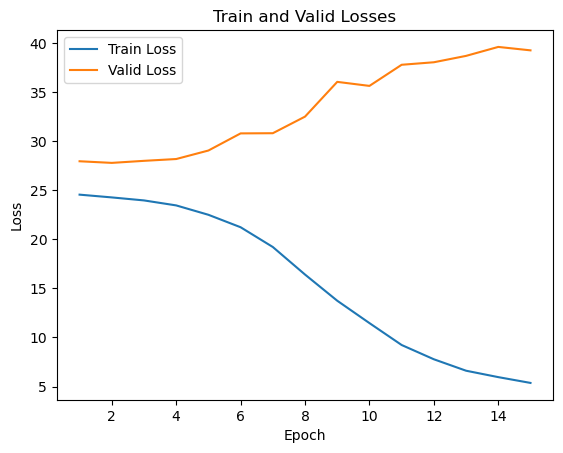

In [105]:
train_loss_df = pd.DataFrame(list(train_loss_dict.items()), columns=['Epoch', 'Train Loss'])
valid_loss_df = pd.DataFrame(list(valid_loss_dict.items()), columns=['Epoch', 'Valid Loss'])

# Merge the DataFrames on 'Epoch' column
merged_df = pd.merge(train_loss_df, valid_loss_df, on='Epoch')

# Plot the losses
plt.plot(merged_df['Epoch'], merged_df['Train Loss'], label='Train Loss')
plt.plot(merged_df['Epoch'], merged_df['Valid Loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

### Tune CNN

### Test CNN

## Potential Resources

https://www.nature.com/articles/s41598-020-57897-9

https://www.nature.com/articles/s41586-019-1559-7 
- first architecture option